In [1]:
import numpy as np
from config import Config
from reconstructor import Reconstructor
import matplotlib.pyplot as plt
import h5py

In [ ]:
c = Config('ConfigFiles/RealG15.yml')
r = Reconstructor(c)

# Read the (x,y) Coordinates and I9 confidence

In [9]:
with h5py.File(c.micFile,'r') as f:
    GrainIDMap = f["GrainID"][:].astype(int)
    grid_x = f["Xcoordinate"][:]
    grid_y = f["Ycoordinate"][:]
    grid_c = f["Convidence"][:]

mask = np.where(GrainIDMap==c.grainID)
x = grid_x[mask]
y = grid_y[mask]
con = grid_c[mask]

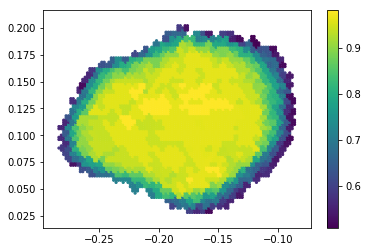

6233


In [10]:
threshold=0.5

fig, ax = plt.subplots()
cax=ax.scatter(x[con>threshold],y[con>threshold],c=con[con>threshold],s=5)
cbar = fig.colorbar(cax)

plt.show()

tmpx=x[con>threshold]
tmpy=y[con>threshold]

print(len(x[con>threshold]))

# Reconstruct strain tensor

In [ ]:
Phase1_Conf, Phase1_S = r.ReconGridsPhase1(tmpx,tmpy)

In [12]:
r.SimPhase1Result(tmpx,tmpy,Phase1_S)

tmpS=Phase1_S.copy()

Phase2_S, history = r.ReconGridsPhase2(tmpx,tmpy,tmpS,fidelity='KL')

1/10, loss=0
2/10, loss=-155468.81983947754
3/10, loss=-224668.5359826088
4/10, loss=-257400.00188469887
5/10, loss=-274752.67014861107
6/10, loss=-286315.1561758518
7/10, loss=-293389.71156829596
8/10, loss=-299820.4308642745
9/10, loss=-304353.4521690011
10/10, loss=-307165.04608231783


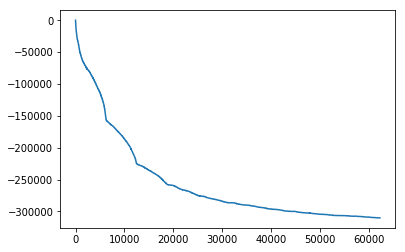

In [13]:
plt.plot(history)
plt.show()

In [16]:
# change the nominal lattice parameters if it's needed 
# when you think you used the wrong lattice parameter in the configure file, you can
# modify the results like here without rerun the reconstruction
MLatticeParam=np.diag([2.92539/2.95, 2.92539/2.95, 4.67399/4.7152])
Phase2_S_corrected = np.einsum('ijk,kl->ijl',Phase2_S,MLatticeParam)

In [17]:
realO,realS = r.Transform2RealS(Phase2_S_corrected)

with h5py.File(c.recFile, 'w') as f:
    f.create_dataset("x", data=tmpx)
    f.create_dataset("y", data=tmpy)

    f.create_dataset("Phase1_Conf", data=Phase1_Conf)
    f.create_dataset("Phase1_S", data=Phase1_S)

    f.create_dataset("Phase2_S", data=Phase2_S)

    f.create_dataset('Phase2_history', data=history)

    f.create_dataset("realS", data=realS)
    f.create_dataset("realO", data=realO)


# Visualizing the reconstruction results

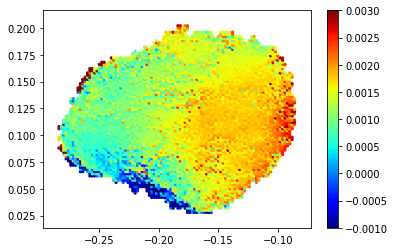

In [18]:
comp=[2,2]
fig, ax = plt.subplots()
cax=ax.scatter(tmpx,tmpy,c=realS[:,comp[0],comp[1]]-1,
               s=5,cmap='jet',
#                vmin=-0.0097,vmax=-0.0059
               vmin=-0.001,vmax=0.003
              )
cbar = fig.colorbar(cax)
# fig.savefig('Szz_1.png',format='png',dpi=300)
plt.show()

In [19]:
# simulate the diffraction pattern from the reconstruction result
simulatedMaps=r.recon.simMap(tmpx,tmpy,Phase2_S,blur=False,dtype=np.uint32)

In [22]:
np.where(r.peakFile['Imgs']['Im75'][:]==np.max(r.peakFile['Imgs']['Im75'][:]))

(array([36, 36, 37, 37, 46, 46, 47, 58]),
 array([180, 181, 180, 181, 204, 205, 204, 185]),
 array([22, 22, 22, 22, 22, 22, 22, 22]))

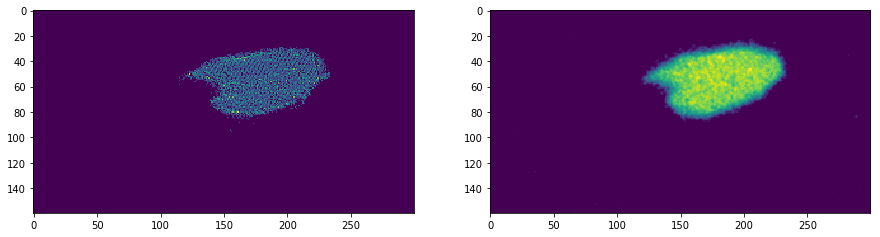

In [23]:
# compare the simulated pattern with the real pattern
ii=75
offset=22
fig,axs=plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(simulatedMaps[:,:,45*ii+offset])
axs[1].imshow(r.peakFile['Imgs']['Im{0:d}'.format(ii)][:,:,offset])
plt.show()